In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import radians, cos, sin, asin, sqrt

In [45]:
#reading train.csv file#
dftrain = pd.read_csv('/Users/sidkapoor/Desktop/Pythonproject NYC/Vishnu/train.csv', index_col=False)

In [76]:
#reading climate data file
weather = pd.read_csv('/Users/sidkapoor/Desktop/Pythonproject NYC/Vishnu/weather.csv', index_col=False)

In [7]:
#for data shape
dftrain.shape
    

(1458644, 11)

# Data Cleaning

City Boundaries, outliers in time duration

In [46]:
dftrain.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [9]:
#Longitude, Latitude cleanup wrt city borders
def boundaries(df):
    df = df[df['pickup_longitude'] <= -73.75]
    df = df[df['pickup_longitude'] >= -74.03]
    df = df[df['pickup_latitude'] <= 40.85]
    df = df[df['pickup_latitude'] >= 40.63]
    df = df[df['dropoff_longitude'] <= -73.75]
    df = df[df['dropoff_longitude'] >= -74.03]
    df = df[df['dropoff_latitude'] <= 40.85]
    df = df[df['dropoff_latitude'] >= 40.63]
    return df

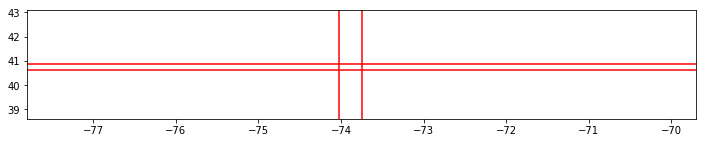

In [49]:
dftrain = boundaries(dftrain)

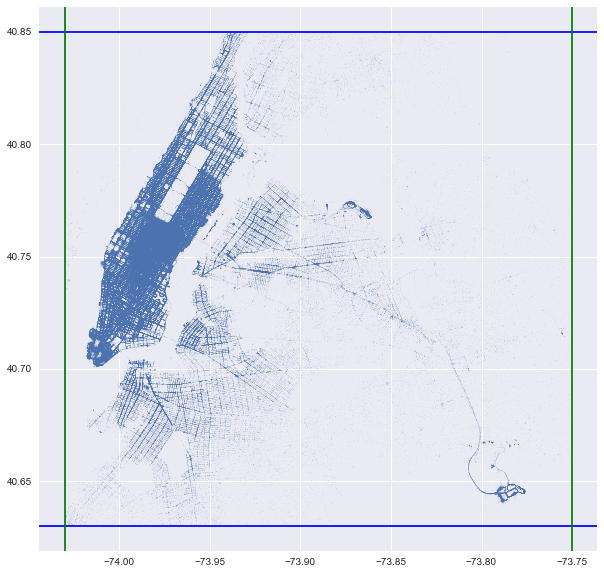

In [54]:
longitude = list(dftrain.pickup_longitude) + list(dftrain.dropoff_longitude)
latitude = list(dftrain.pickup_latitude) + list(dftrain.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'*', alpha = 0.4, markersize = 0.5) 
plt.axhline(y=40.85, color='b', linestyle='-')
plt.axhline(y=40.63, color='b', linestyle='-')
plt.axvline(x=-73.75, color='g', linestyle='-')
plt.axvline(x=-74.03, color='g', linestyle='-')
plt.show()

In [51]:
#Trip duration cleanup -
def cleanduration(df):
    limits  = [np.percentile(df['trip_duration'], 0.5), np.percentile(df['trip_duration'], 99.5)]
    df1=df[(df.trip_duration >= limits[0] ) & (df.trip_duration <= limits[1])]
    return df1

In [52]:
dftrain = cleanduration(dftrain)

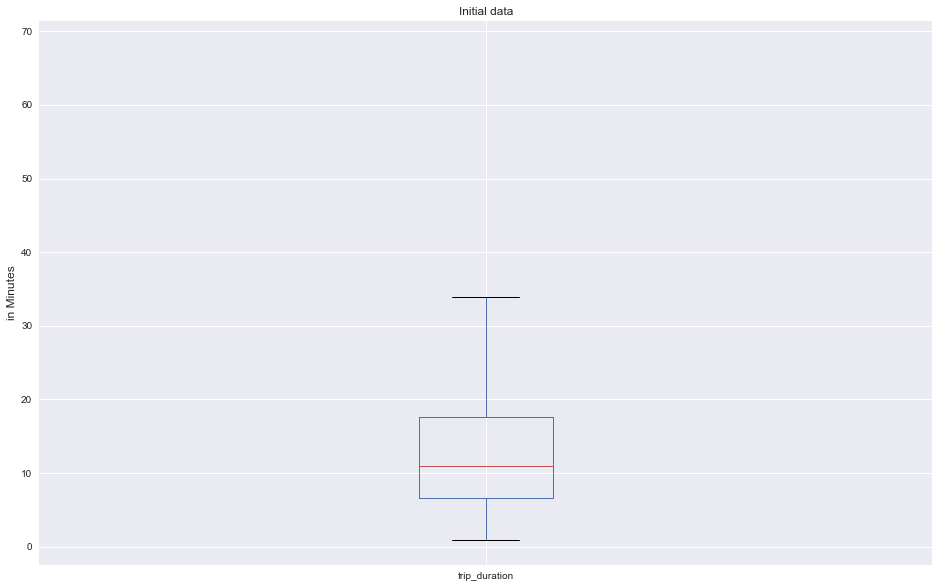

In [53]:
train_y=pd.DataFrame(dftrain['trip_duration']/60)
train_f=pd.DataFrame(dftrain['trip_duration']/60)
train_y.boxplot()
plt.ylabel('in Minutes', fontsize=12)
plt.title("Initial data")
plt.show()

In [13]:
dftrain.shape

(1424814, 11)

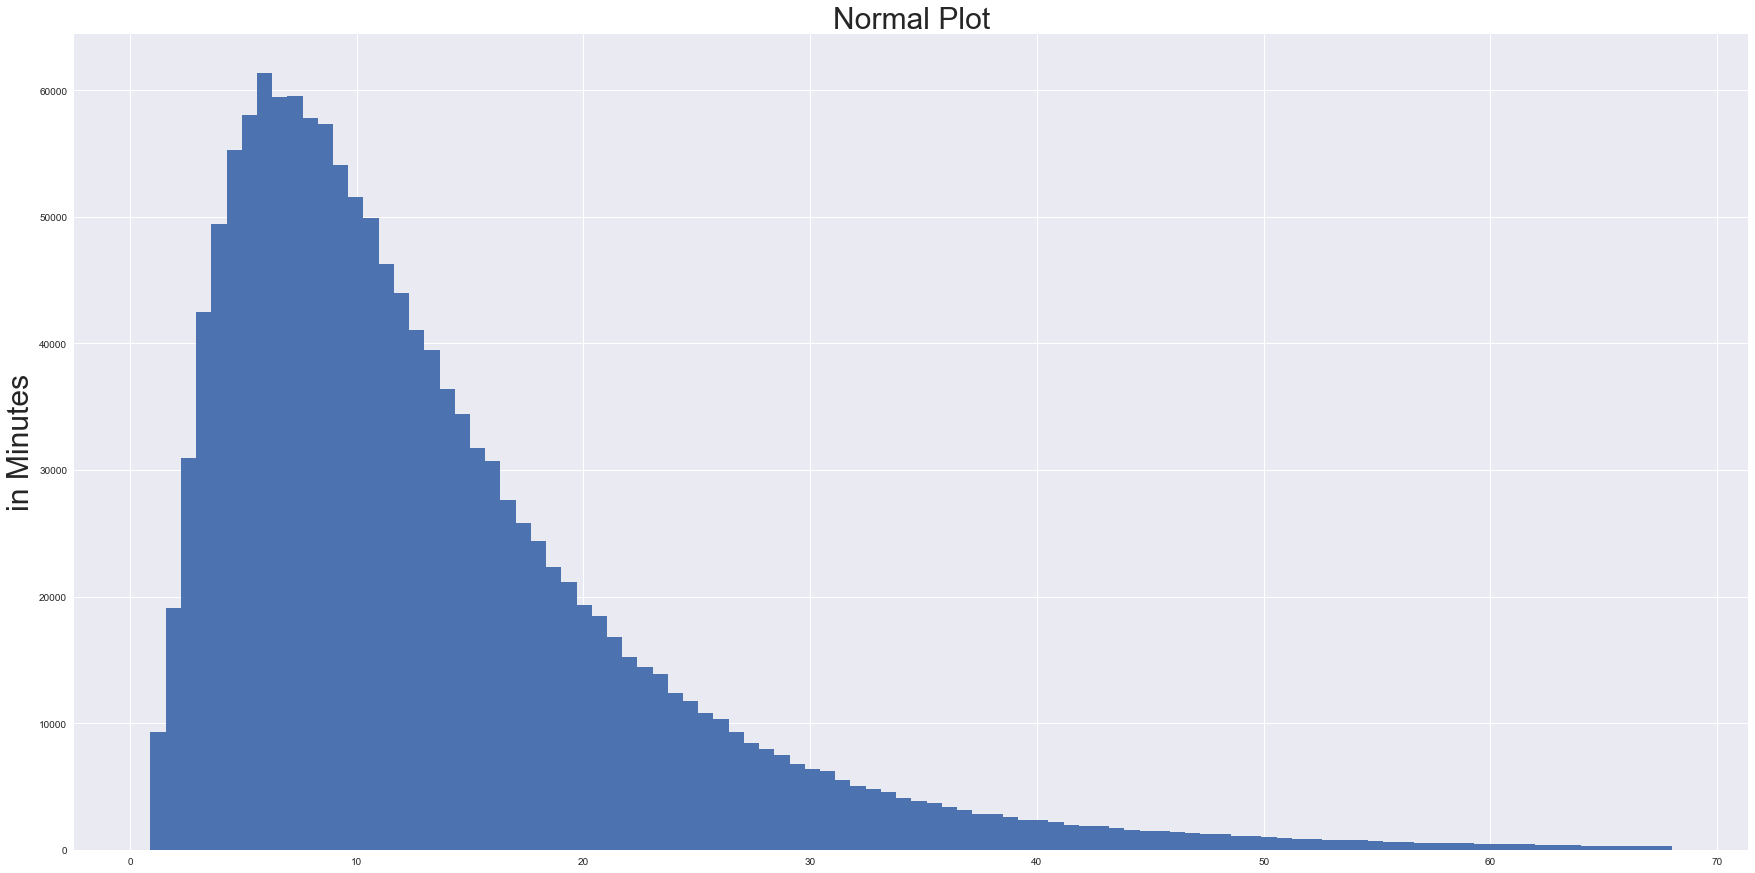

In [55]:
plt.figure(figsize=(30,15))
plt.hist(dftrain.trip_duration/60, bins=100)
plt.title('Normal Plot', fontsize= 30)
plt.ylabel('in Minutes',fontsize= 30)
plt.show()

# Factor Extraction

# Extracting features from Timestamp

In [56]:
#Changing time stamp format
def timedtype(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime']= pd.to_datetime(df['dropoff_datetime'])
    return df

In [57]:
dftrain = timedtype(dftrain)

In [71]:
#Extracting individual parameters from fatestamp
def dateextract(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['drop_date'] = df['dropoff_datetime'].dt.date

    df['pickup_time'] = df['pickup_datetime'].dt.time
    df['drop_time'] = df['dropoff_datetime'].dt.time

    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['drop_hour'] = df['dropoff_datetime'].dt.hour

    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['drop_month'] = df['dropoff_datetime'].dt.month

    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['drop_weekday'] = df['dropoff_datetime'].dt.weekday
    
    df['yday'] = df['pickup_datetime'].dt.dayofyear

In [72]:
dateextract(dftrain)

In [73]:
dftrain.shape

(1424814, 23)

# Distance calculation

In [64]:
#Calculating Distance between Co-ordinates
#Distance calculation
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km
def distance(df):
    df['distance'] = df.apply(lambda x: haversine(x.pickup_longitude,x.pickup_latitude,x.dropoff_longitude,x.dropoff_latitude), axis=1)

In [65]:
distance(dftrain)

In [66]:
dftrain.shape

(1424814, 23)

# Adding weather Data

In [74]:
#adding weather data
def addingweather(df):
    weather['date'] = pd.to_datetime(weather['date'])
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])
    weather.rename(columns={'date':'pickup_date'},inplace=True)
    df=pd.merge(df,weather,on='pickup_date',how='left')
    return df


In [77]:
dftrain = addingweather(dftrain)

# Grouping the categorical values based on similar behaviour

# Number of trips by month

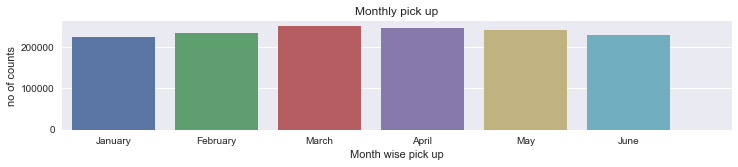

In [78]:
#Monthly
month_names=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(12,2))
month_wise=dftrain.groupby('pickup_month').agg({'id':'count'}).reset_index()
sns.barplot(x='pickup_month',y='id',data=month_wise)
plt.xlabel('Month wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),month_names[:6])
plt.title('Monthly pick up')
pass

Lower number of trips in first two months may be due to "Winter". Next 3 months are showing similar behavior with number of trips. So, we are grouping months into three seasons

In [79]:
#For the train dataset, devide months into seasons
def season(dfv4):
    dfv4['s1']=dfv4['pickup_month']<=2
    dfv4['s2']=dfv4['pickup_month'].between(3,5)
    dfv4['s3']=dfv4['pickup_month']>=6

In [80]:
season(dftrain)

# Number of trips by week day

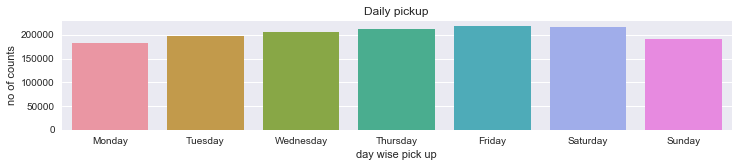

In [81]:
#Day of a week
weekday_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12,2))
day_wise=dftrain.groupby('pickup_weekday').agg({'id':'count'}).reset_index()
sns.barplot(x='pickup_weekday',y='id',data=day_wise)
plt.xlabel('day wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),weekday_names)
plt.title('Daily pickup')
pass


There is no particular trend in weekday vs number of trips. so, we take week days as individual features

In [82]:
def weekdaydummy(dfv4):
    dfv4["pwd0"] = dfv4['pickup_weekday']==0
    dfv4["pwd1"] = dfv4['pickup_weekday']==1
    dfv4["pwd2"] = dfv4['pickup_weekday']==2
    dfv4["pwd3"] = dfv4['pickup_weekday']==3
    dfv4["pwd4"] = dfv4['pickup_weekday']==4
    dfv4["pwd5"] = dfv4['pickup_weekday']==5
    dfv4["pwd6"] = dfv4['pickup_weekday']==6

In [83]:
weekdaydummy(dftrain)

In [84]:
def weekdaydist(dfv4):
    dfv4["weektime"] = dfv4['pickup_weekday'].between(0,4)
    dfv4["weekendtime"] = dfv4['pickup_weekday'].between(5,6)

In [85]:
weekdaydist(dftrain)

We tried grouping week days, but it is showing negative effect on ML model. So, we withdrew the approach on weekday grouping

# Number of trips by hour of the day

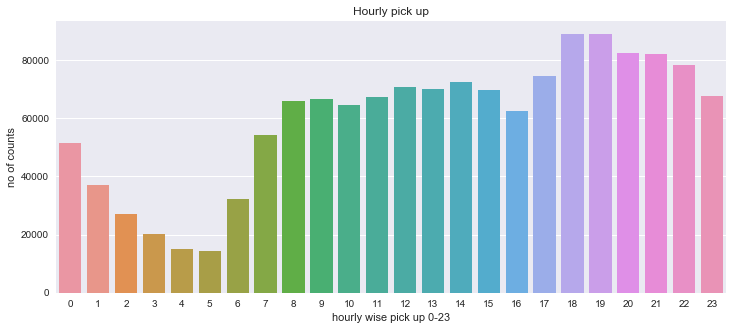

In [86]:
#Hourly
plt.figure(figsize=(12,5))
hour_wise=dftrain.groupby('pickup_hour').agg({'id':'count'}).reset_index()
sns.barplot(x='pickup_hour',y='id',data=hour_wise)
plt.xlabel('hourly wise pick up 0-23')
plt.ylabel('no of counts')
plt.title('Hourly pick up')
pass

As we see some similarity in behaviour through some time periods, we divided the whole day into 4 time zones

In [87]:
def timebins(dfv4):
    dfv4['timeperiod1']=dfv4['pickup_hour'].between(0,6)
    dfv4['timeperiod2']=dfv4['pickup_hour'].between(7,10)
    dfv4['timeperiod3']=dfv4['pickup_hour'].between(11,16)
    dfv4['timeperiod4']=dfv4['pickup_hour'].between(17,23)

In [88]:
timebins(dftrain)

# Number of Passengers vs Average trip duration

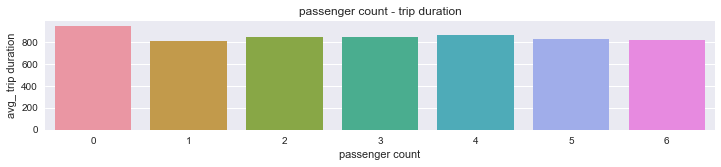

In [89]:
#Number of Passengers vs Average trip duration
plt.figure(figsize=(12,2))
passenger=dftrain.groupby('passenger_count').agg({'trip_duration':'mean'}).reset_index()
sns.barplot(x='passenger_count',y='trip_duration',data=passenger)
plt.xlabel('passenger count')
plt.ylabel('avg_ trip duration')
plt.title('passenger count - trip duration')

# As there is no much effect of number of passengers on trip duration, we are not considering 

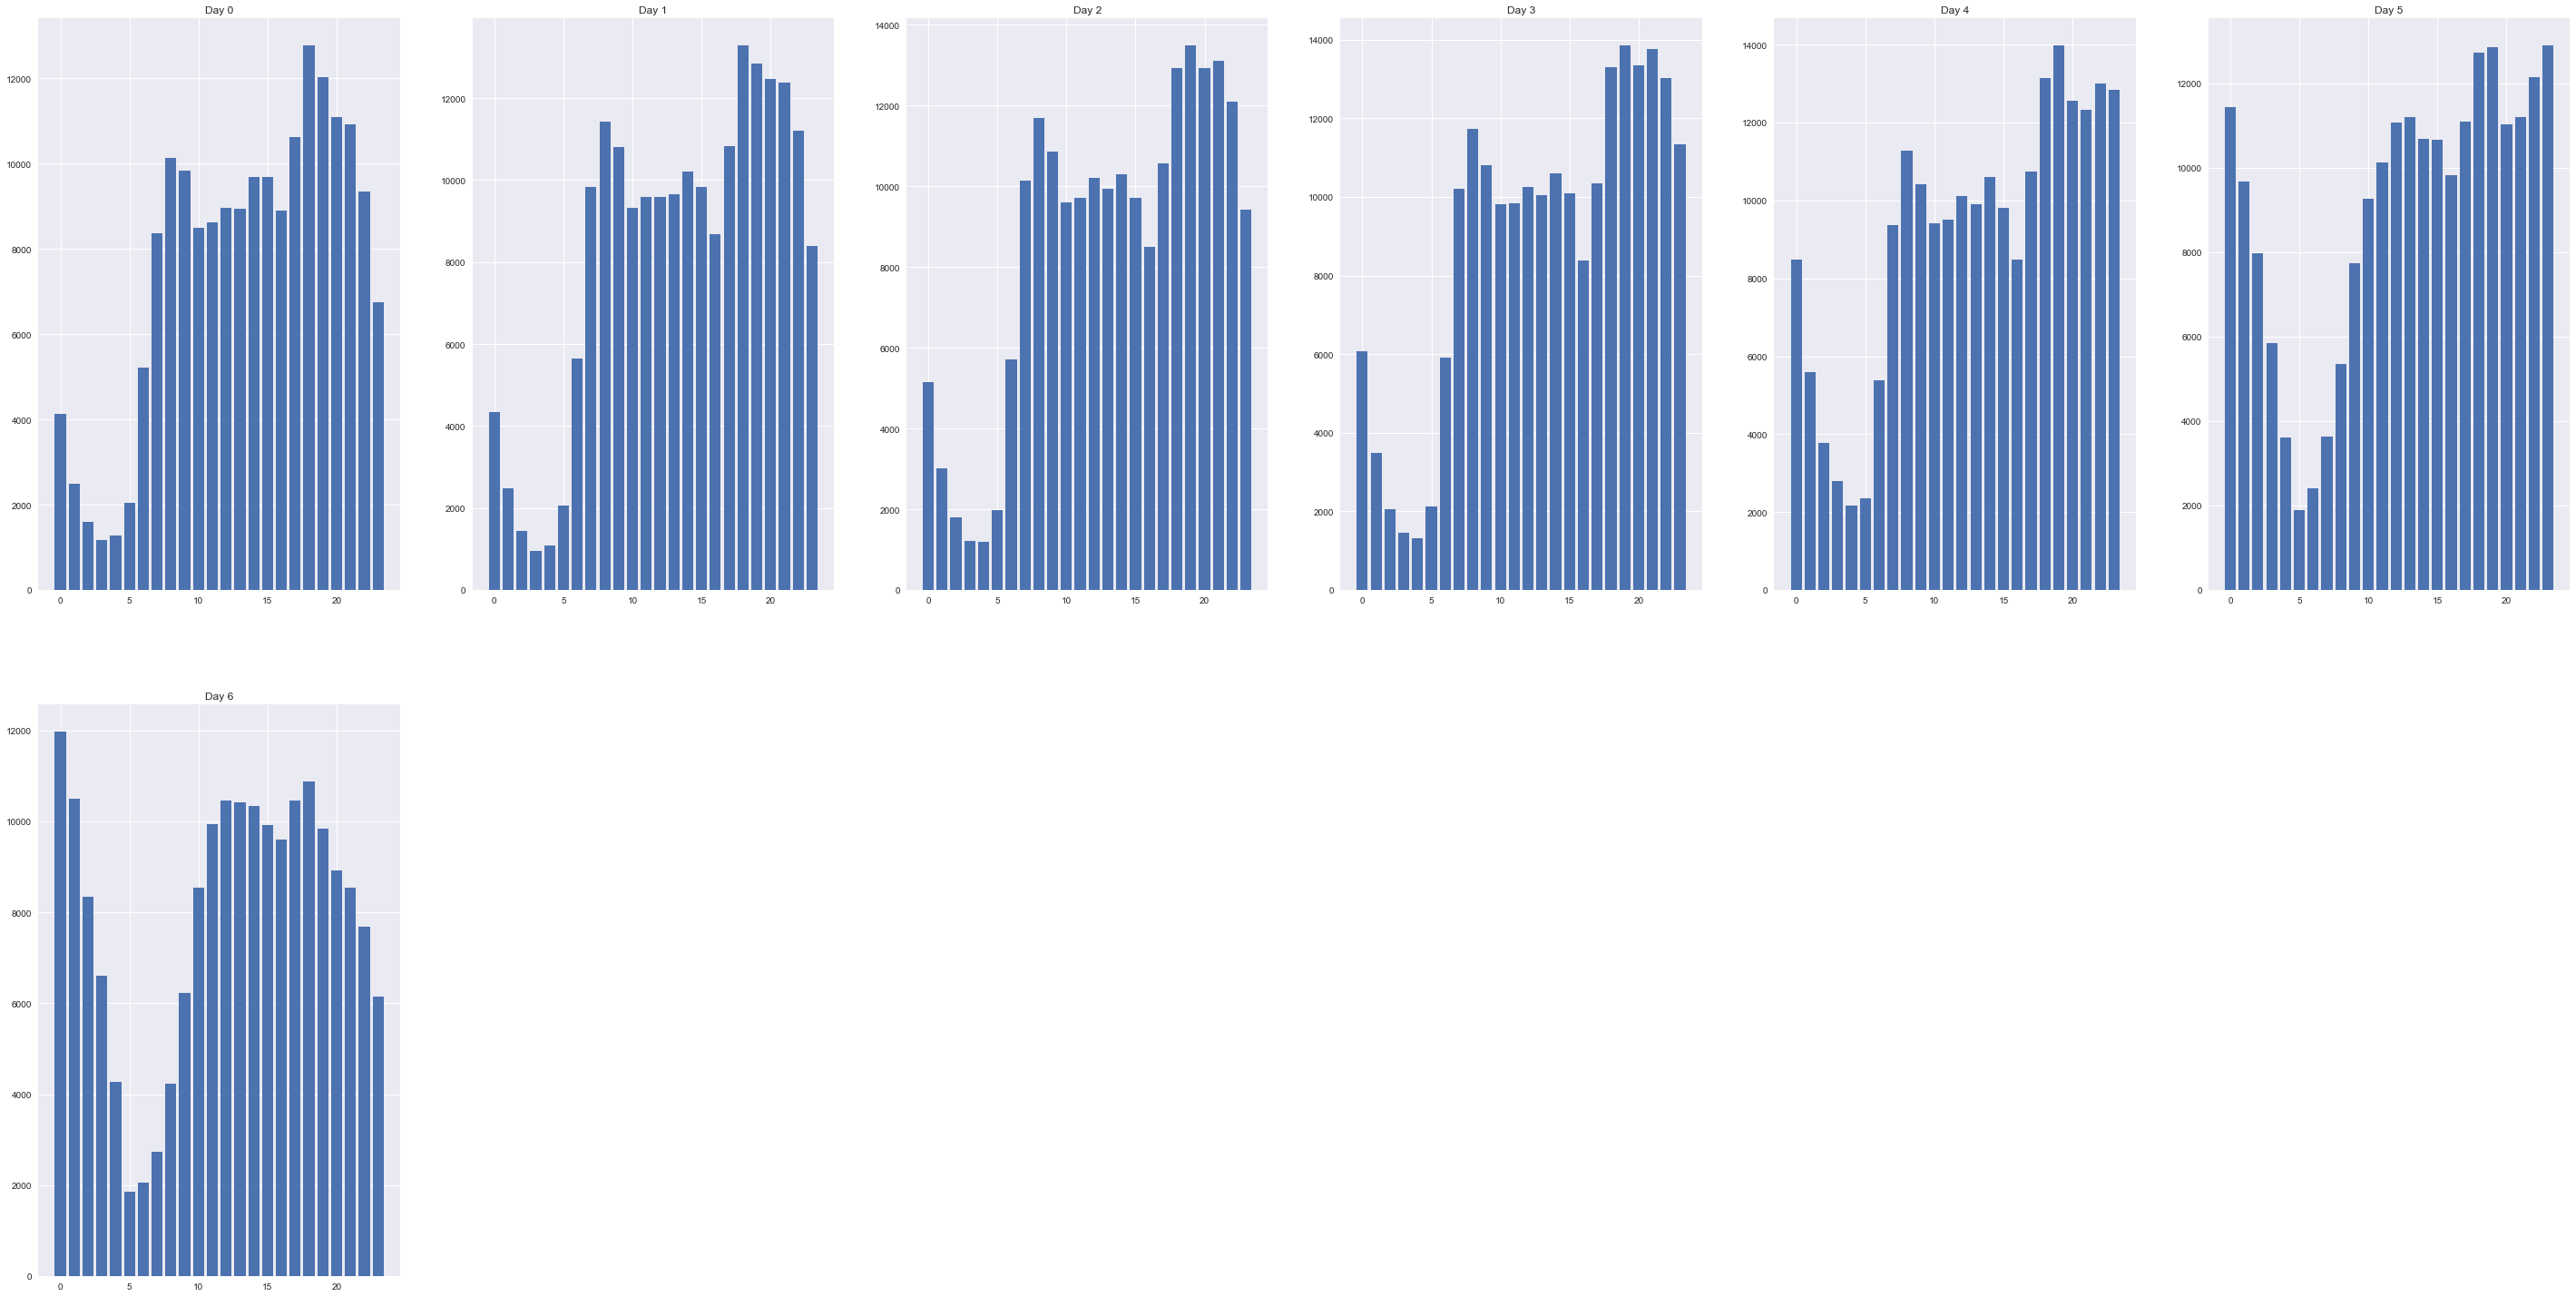

In [93]:
plt.figure(figsize=(50,95))
week = [0,1,2,3,4,5,6]
j=0
for i in week:
    j+=1
    plt.subplot(7,6,j)
    plt.title("Day %s" % i)
    wk_hr =dftrain[dftrain['pickup_weekday'] == i].groupby(['pickup_hour']).id.count()
    plt.bar(wk_hr.index, wk_hr.values)

plt.show()

# Day 0 corresponds to monday ans similarly day 1 corresponds to tuesday and so on
# we can see that day0 to day 4 have same trends, and, day 5 and day 6 have same trends.


# Extracting relevent features from weather

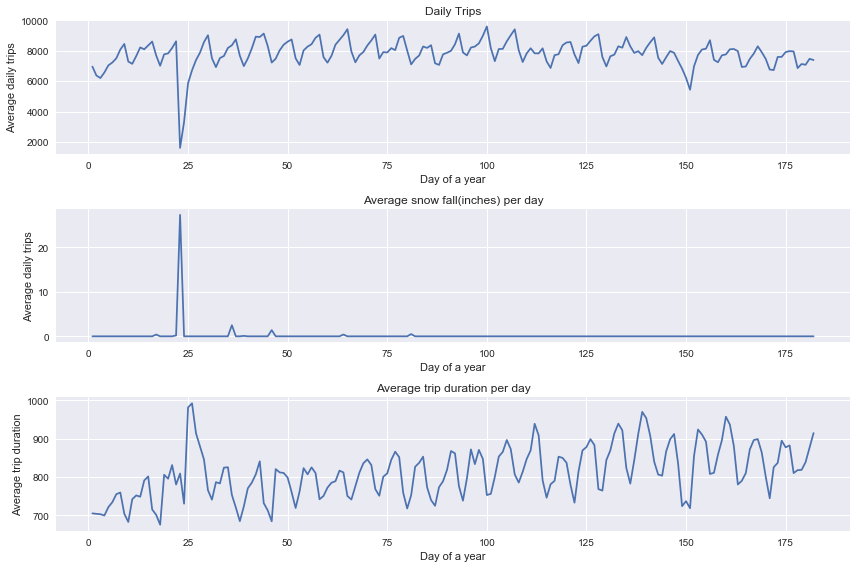

In [94]:
#Weather data comarison
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12, 8))

figure=plt.subplot(311)
table=dftrain.groupby('yday').agg({'id':'count'})
plt.plot(table)
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Daily Trips')
pass

figure=plt.subplot(312)
data=dftrain.groupby('yday').agg({'snow fall':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Average snow fall(inches) per day')
plt.plot(data)
pass

figure=plt.subplot(313)
data=dftrain.groupby('yday').agg({'trip_duration':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average trip duration')
plt.title('Average trip duration per day')
plt.plot(data)
pass

fig.tight_layout()

As we see the graphs above, when there was snow fall, there was a drop in number of trips and increase in average trip duration. So, we take snow fall a feature

In [95]:
dftrain.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_date', u'drop_date', u'pickup_time',
       u'drop_time', u'pickup_hour', u'drop_hour', u'pickup_month',
       u'drop_month', u'pickup_weekday', u'drop_weekday', u'yday', u'distance',
       u'maximum Temperature', u'minimum Temperature', u'average Temperature',
       u'precipitation', u'snow fall', u'snow depth', u's1', u's2', u's3',
       u'pwd0', u'pwd1', u'pwd2', u'pwd3', u'pwd4', u'pwd5', u'pwd6',
       u'weektime', u'weekendtime', u'timeperiod1', u'timeperiod2',
       u'timeperiod3', u'timeperiod4'],
      dtype='object')

# Model 1

# Selecting relevant features

In [100]:
features = ["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count",'weektime','weekendtime',"distance","snow fall","s1","s2","s3",'timeperiod1', 'timeperiod2', 'timeperiod3', 'timeperiod4']
X = dftrain[features]
y = dftrain['trip_duration']

In [101]:
X_Train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [103]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train,y_train)
pred=lm.predict(X_test)
#accuracy=round(lm.score(X_train,y_train)*100,2)
#accuracy
pred

array([  628.46875 ,   544.5625  ,   279.625   , ...,   443.28125 ,
        1090.15625 ,   841.296875])

In [119]:
x = X_Train
Y = Y_train
#x=sm.add_constant(x)
model=sm.OLS(Y,x.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 1.460e+05
Date:                Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                        23:55:41   Log-Likelihood:            -8.3409e+06
No. Observations:             1139851   AIC:                         1.668e+07
Df Residuals:                 1139837   BIC:                         1.668e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude  -1425.2640     11.417   -124.834      0.000   -1447.642   -1402.886
pickup_latitude    1109.2583     14.895     74.473      0.000    1080.065    1138.452
dropoff_longitude -1489.6570     12.380   -120.329      0.000   -1513.921   -1465.393
dropoff_latitude   -927.9417     13.312    -69.709      0.000    -954.032    -901.851
passenger_count       3.5650      0.260     13.709      0.000       3.055       4.075
weektime          -1.027e+05    722.243   -142.263      0.000   -1.04e+05   -1.01e+05
weekendtime       -1.028e+05    722.249   -142.377      0.000   -1.04e+05   -1.01e+05
distance            144.0998      0.133   1085.262      0.000     143.840     144.360
snow fall             6.5609      0.366     17.920      0.000       5.843       7.278
s1                -6.856e+04    481.496   -142.398      0.000   -6.95e+04   -6.76e+04
s2                -6.852e+04    481.499   -142.312      0.000   -6.95e+04   -6.76e+04
s3                -6.849e+04    481.498   -142.250      0.000   -6.94e+04   -6.75e+04
timeperiod1       -5.156e+04    361.091   -142.788      0.000   -5.23e+04   -5.09e+04
timeperiod2       -5.135e+04    361.138   -142.193      0.000   -5.21e+04   -5.06e+04
timeperiod3       -5.127e+04    361.131   -141.980      0.000    -5.2e+04   -5.06e+04
timeperiod4        -5.14e+04    361.134   -142.318      0.000   -5.21e+04   -5.07e+04
==============================================================================
Omnibus:                   342640.843   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1936217.181
Skew:                           1.334   Prob(JB):                         0.00
Kurtosis:                       8.801   Cond. No.                     2.03e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.94e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [120]:
Y_test = Y_test.astype(float)
Yt=Y_test.values
diff = (Yt-pred)

In [121]:
def classification(df1,df2):
    a = []
    i=0
    for i in range (0,len(df1)):
        if abs(df1[i])<abs(df2[i]*0.3):
            a.append(1)
        else:
            a.append(0)
    return a

In [122]:
classarray = classification(diff,Yt)

In [123]:
accuracy = 1.0*classarray.count(1)/(classarray.count(1)+classarray.count(0))

In [125]:
accuracy*100

51.51475805630906

# Model 2

In [131]:
import geohash as pgh
precision=6
dftrain['pickup_geohash'] = dftrain.apply(lambda dftrain: pgh.encode(dftrain.pickup_latitude, dftrain.pickup_longitude, precision), axis=1)
dftrain['drop_geohash'] = dftrain.apply(lambda dftrain: pgh.encode(dftrain.dropoff_latitude, dftrain.dropoff_longitude, precision), axis=1)


In [138]:
dftrain['route'] = dftrain['pickup_geohash'] + '_'+ dftrain['drop_geohash']

In [139]:
train, test = train_test_split(dftrain, test_size=0.2)

In [140]:
a = {'trip_duration':['mean'],'id':['nunique']}
km=train.groupby(['pickup_hour','pickup_weekday','route']).agg(a).reset_index()

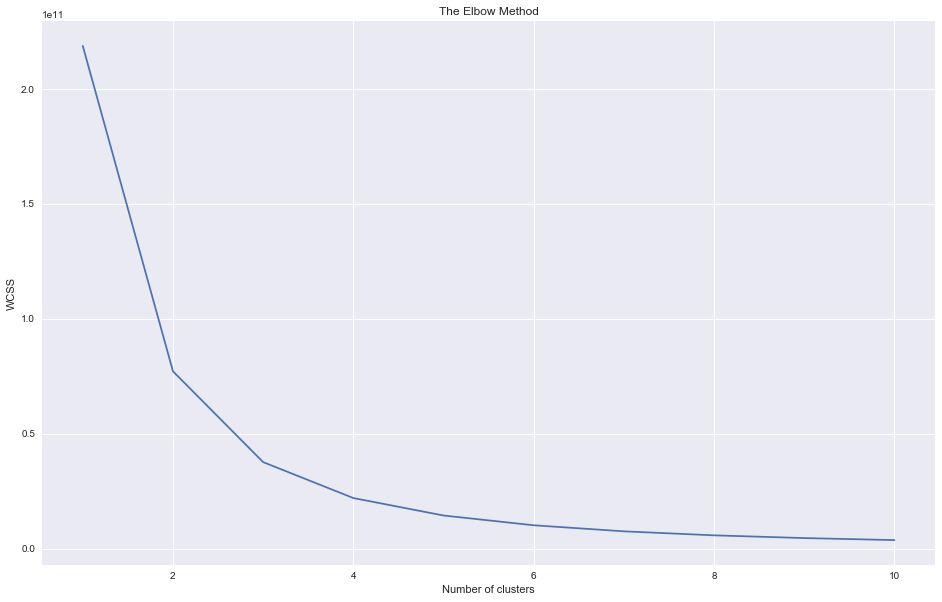

In [141]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(km[['trip_duration','id']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# We will select K = 4 from the above graph

In [144]:
from sklearn.preprocessing import StandardScaler
sc_X= StandardScaler()
km['std_trip_duration']=sc_X.fit_transform(km['trip_duration'])
km['std_trip_count']=sc_X.fit_transform(km['id'])

In [147]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
km['cluster'] = kmeans.fit_predict(km[['trip_duration','id']])

In [148]:
km['hr_wk_route'] = km['pickup_hour'].apply(str) + '_'+km['pickup_weekday'].apply(str)+'_'+km['route']
km.columns = km.columns.droplevel(1)

In [149]:
cluster_summary=km.groupby(['cluster'])['trip_duration'].mean().reset_index()
#km.columns=km.columns.droplevel()
#km.columns
cluster_summary

,cluster,trip_duration
0,0,447.675324
1,1,1681.585586
2,2,2811.208344
3,3,994.136859


# Testing on test data split/ Prediction

In [150]:
test['hr_wk_route'] = test['pickup_hour'].apply(str) + '_'+test['pickup_weekday'].apply(str)+'_'+test['route']

In [154]:
cluster_pred=km.groupby(['hr_wk_route'])['trip_duration'].mean().reset_index()
test2=pd.merge(test,cluster_pred,on='hr_wk_route',how='left')

In [155]:
test2['diff'] = (test2['trip_duration_x']-test2['trip_duration_y'])**2
test2['mean_diff'] = ((test2['trip_duration_x']-(test2['trip_duration_x']).mean()))**2
test3=test2.dropna(axis=0, how='any')
1-(sum(test3['diff'])/sum(test3['mean_diff'])),test3.shape

(0.66083302840169089, (208894, 52))

# Accuracy

In [157]:
acc=(test3['trip_duration_x']-test3['trip_duration_y']).values
yt=test3['trip_duration_x'].values
len(yt)
 
classarray = classification(acc,yt)
accuarcy = float(classarray.count(1))/(classarray.count(1)+classarray.count(0))
accuarcy*100

57.48705084875583

# Model 3

# Calculating Geohashs on precision=4

In [158]:
precision=4
dftrain['pickup_geohash4'] = dftrain.apply(lambda dftrain: pgh.encode(dftrain.pickup_latitude, dftrain.pickup_longitude, precision), axis=1)
dftrain['drop_geohash4'] = dftrain.apply(lambda dftrain: pgh.encode(dftrain.dropoff_latitude, dftrain.dropoff_longitude, precision), axis=1)



In [159]:
dftrain['route2'] = dftrain['pickup_geohash4'] + '_'+ dftrain['drop_geohash4']

In [160]:
dftrain.groupby('route2').id.count().sort_values(ascending = False)


route2
dr5r_dr5r    1144612
dr5r_dr72     110690
dr72_dr5r      70529
dr72_dr72      59203
dr5x_dr5r      22037
dr5r_dr5x      11366
dr5x_dr5x       2711
dr5x_dr72       2339
dr72_dr5x        928
dr5r_dr78        281
dr5x_dr78         84
dr72_dr78         26
dr78_dr78          4
dr78_dr72          2
dr78_dr5r          2
Name: id, dtype: int64

In [162]:
dftrain = pd.get_dummies(dftrain, columns=['route2'])

In [163]:
dftrain = pd.get_dummies(dftrain, columns=['pickup_hour'])
dftrain = pd.get_dummies(dftrain, columns=['pickup_weekday'])
dftrain = pd.get_dummies(dftrain, columns=['vendor_id'])
dftrain = pd.get_dummies(dftrain, columns=['store_and_fwd_flag'])

In [164]:
y = dftrain[['trip_duration']]
x = dftrain[[u'route2_dr5r_dr5r',
       u'route2_dr5r_dr5x', u'route2_dr5r_dr72', u'route2_dr5r_dr78',
       u'route2_dr5x_dr5r', u'route2_dr5x_dr5x', u'route2_dr5x_dr72',
       u'route2_dr5x_dr78', u'route2_dr72_dr5r', u'route2_dr72_dr5x',
       u'route2_dr72_dr72', u'route2_dr72_dr78', u'route2_dr78_dr5r',
       u'route2_dr78_dr72', u'route2_dr78_dr78', u'pickup_hour_0',
       u'pickup_hour_1', u'pickup_hour_2', u'pickup_hour_3', u'pickup_hour_4',
       u'pickup_hour_5', u'pickup_hour_6', u'pickup_hour_7', u'pickup_hour_8',
       u'pickup_hour_9', u'pickup_hour_10', u'pickup_hour_11',
       u'pickup_hour_12', u'pickup_hour_13', u'pickup_hour_14',
       u'pickup_hour_15', u'pickup_hour_16', u'pickup_hour_17',
       u'pickup_hour_18', u'pickup_hour_19', u'pickup_hour_20',
       u'pickup_hour_21', u'pickup_hour_22', u'pickup_hour_23',
       u'pickup_weekday_0', u'pickup_weekday_1', u'pickup_weekday_2',
       u'pickup_weekday_3', u'pickup_weekday_4', u'pickup_weekday_5',
       u'pickup_weekday_6', u'vendor_id_1', u'vendor_id_2',
       u'store_and_fwd_flag_N', u'store_and_fwd_flag_Y',u'distance',u'average Temperature',u'precipitation', u'snow fall', u'snow depth']]

In [165]:
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=.8,test_size=.2,random_state = 0)

In [166]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1139851, 55), (284963, 55), (1139851, 1), (284963, 1))

# Predicting on test data and OLS summary

In [167]:
from sklearn.linear_model import LinearRegression
# Fitting Multiple Linear regression
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [168]:
import statsmodels.formula.api as sm
x = x_train
Y = y_train
#x=sm.add_constant(x)
model=sm.OLS(Y,x.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                 4.485e+04
Date:                Sat, 09 Dec 2017   Prob (F-statistic):               0.00
Time:                        01:24:54   Log-Likelihood:            -8.2790e+06
No. Observations:             1139851   AIC:                         1.656e+07
Df Residuals:                 1139800   BIC:                         1.656e+07
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
route2_dr5r_dr5r     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5r_dr5x     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5r_dr72     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5r_dr78     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5x_dr5r     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5x_dr5x     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5x_dr72     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr5x_dr78     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr72_dr5r     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr72_dr5x     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr72_dr72     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr72_dr78     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr78_dr5r     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr78_dr72     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
route2_dr78_dr78     -3.774e+10   5.46e+10     -0.691      0.490   -1.45e+11    6.93e+10
pickup_hour_0          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_1          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_2          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_3          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_4          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_5          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_6          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_7          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_8          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_9          7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_10         7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_11         7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_12         7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_13         7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_14         7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_15         7.85e+11   1.14e+12      0.691      0.490   -1.44e+12    3.01e+12
pickup_hour_16         7.85e+11   1.14e+12      0.691    

In [169]:
# Predicting the test set
y_pred = regressor.predict(x_test)

# Accuracy

In [170]:
y_test = y_test.astype(float)
Yt=y_test.values
diff = (Yt-y_pred)

In [171]:
def classification(df1,df2):
    a = []
    i=0
    for i in range (0,len(df1)):
        if abs(df1[i])<abs(df2[i]*0.3):
            a.append(1)
        else:
            a.append(0)
    return a

In [172]:
classarray = classification(diff,Yt)
accuracy = 1.0*classarray.count(1)/(classarray.count(1)+classarray.count(0))
accuracy*100

54.39548292234431

# Model 4

# Clustering on Latitude and Longitude using k-means clustering

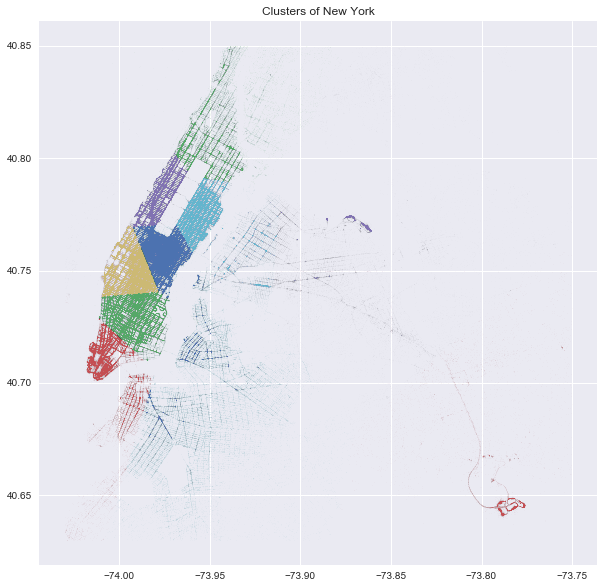

In [173]:
longitude = list(dftrain.pickup_longitude) + list(dftrain.dropoff_longitude)
latitude = list(dftrain.pickup_latitude) + list(dftrain.dropoff_latitude)
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'*', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

In [174]:
loc_df.groupby('label').longitude.count().sort_values(ascending=False)

label
7    688885
5    548905
2    477931
1    414732
9    241878
8    184722
3     99681
4     76804
6     74639
0     41451
Name: longitude, dtype: int64

In [176]:
dftrain['pickup_cluster'] = kmeans.predict(dftrain[['pickup_longitude','pickup_latitude']])
dftrain['dropoff_cluster'] = kmeans.predict(dftrain[['dropoff_longitude','dropoff_latitude']])

In [177]:
dftrain['pickup_cluster'] = dftrain['pickup_cluster'].apply(str)
dftrain['dropoff_cluster'] = dftrain['dropoff_cluster'].apply(str)

In [178]:
dftrain['route_cluster'] = dftrain['pickup_cluster'] + '_'+ dftrain['dropoff_cluster']

In [185]:
dftrain = pd.get_dummies(dftrain, columns=['route_cluster'])

In [186]:
tt = dftrain[['trip_duration','distance','average Temperature','precipitation','snow fall','snow depth','pickup_hour_0','pickup_hour_1','pickup_hour_2','pickup_hour_3','pickup_hour_4','pickup_hour_5','pickup_hour_6','pickup_hour_7','pickup_hour_8','pickup_hour_9','pickup_hour_10','pickup_hour_11','pickup_hour_12','pickup_hour_13','pickup_hour_14','pickup_hour_15','pickup_hour_16','pickup_hour_17','pickup_hour_18','pickup_hour_19','pickup_hour_20','pickup_hour_21','pickup_hour_22','pickup_hour_23','pickup_weekday_0','pickup_weekday_1','pickup_weekday_2','pickup_weekday_3','pickup_weekday_4','pickup_weekday_5','pickup_weekday_6','vendor_id_1','vendor_id_2','store_and_fwd_flag_N','store_and_fwd_flag_Y','route_cluster_0_0','route_cluster_0_1','route_cluster_0_2','route_cluster_0_3','route_cluster_0_4','route_cluster_0_5','route_cluster_0_6','route_cluster_0_7','route_cluster_0_8','route_cluster_0_9','route_cluster_1_0','route_cluster_1_1','route_cluster_1_2','route_cluster_1_3','route_cluster_1_4','route_cluster_1_5','route_cluster_1_6','route_cluster_1_7','route_cluster_1_8','route_cluster_1_9','route_cluster_2_0','route_cluster_2_1','route_cluster_2_2','route_cluster_2_3','route_cluster_2_4','route_cluster_2_5','route_cluster_2_6','route_cluster_2_7','route_cluster_2_8','route_cluster_2_9','route_cluster_3_0','route_cluster_3_1','route_cluster_3_2','route_cluster_3_3','route_cluster_3_4','route_cluster_3_5','route_cluster_3_6','route_cluster_3_7','route_cluster_3_8','route_cluster_3_9','route_cluster_4_0','route_cluster_4_1','route_cluster_4_2','route_cluster_4_3','route_cluster_4_4','route_cluster_4_5','route_cluster_4_6','route_cluster_4_7','route_cluster_4_8','route_cluster_4_9','route_cluster_5_0','route_cluster_5_1','route_cluster_5_2','route_cluster_5_3','route_cluster_5_4','route_cluster_5_5','route_cluster_5_6','route_cluster_5_7','route_cluster_5_8','route_cluster_5_9','route_cluster_6_0','route_cluster_6_1','route_cluster_6_2','route_cluster_6_3','route_cluster_6_4','route_cluster_6_5','route_cluster_6_6','route_cluster_6_7','route_cluster_6_8','route_cluster_6_9','route_cluster_7_0','route_cluster_7_1','route_cluster_7_2','route_cluster_7_3','route_cluster_7_4','route_cluster_7_5','route_cluster_7_6','route_cluster_7_7','route_cluster_7_8','route_cluster_7_9','route_cluster_8_0','route_cluster_8_1','route_cluster_8_2','route_cluster_8_3','route_cluster_8_4','route_cluster_8_5','route_cluster_8_6','route_cluster_8_7','route_cluster_8_8','route_cluster_8_9','route_cluster_9_0','route_cluster_9_1','route_cluster_9_2','route_cluster_9_3','route_cluster_9_4','route_cluster_9_5','route_cluster_9_6','route_cluster_9_7','route_cluster_9_8','route_cluster_9_9']]

In [187]:
y = tt['trip_duration'].values
x = tt[['distance','average Temperature','precipitation','snow fall','snow depth','pickup_hour_0','pickup_hour_1','pickup_hour_2','pickup_hour_3','pickup_hour_4','pickup_hour_5','pickup_hour_6','pickup_hour_7','pickup_hour_8','pickup_hour_9','pickup_hour_10','pickup_hour_11','pickup_hour_12','pickup_hour_13','pickup_hour_14','pickup_hour_15','pickup_hour_16','pickup_hour_17','pickup_hour_18','pickup_hour_19','pickup_hour_20','pickup_hour_21','pickup_hour_22','pickup_hour_23','pickup_weekday_0','pickup_weekday_1','pickup_weekday_2','pickup_weekday_3','pickup_weekday_4','pickup_weekday_5','pickup_weekday_6','vendor_id_1','vendor_id_2','store_and_fwd_flag_N','store_and_fwd_flag_Y','route_cluster_0_0','route_cluster_0_1','route_cluster_0_2','route_cluster_0_3','route_cluster_0_4','route_cluster_0_5','route_cluster_0_6','route_cluster_0_7','route_cluster_0_8','route_cluster_0_9','route_cluster_1_0','route_cluster_1_1','route_cluster_1_2','route_cluster_1_3','route_cluster_1_4','route_cluster_1_5','route_cluster_1_6','route_cluster_1_7','route_cluster_1_8','route_cluster_1_9','route_cluster_2_0','route_cluster_2_1','route_cluster_2_2','route_cluster_2_3','route_cluster_2_4','route_cluster_2_5','route_cluster_2_6','route_cluster_2_7','route_cluster_2_8','route_cluster_2_9','route_cluster_3_0','route_cluster_3_1','route_cluster_3_2','route_cluster_3_3','route_cluster_3_4','route_cluster_3_5','route_cluster_3_6','route_cluster_3_7','route_cluster_3_8','route_cluster_3_9','route_cluster_4_0','route_cluster_4_1','route_cluster_4_2','route_cluster_4_3','route_cluster_4_4','route_cluster_4_5','route_cluster_4_6','route_cluster_4_7','route_cluster_4_8','route_cluster_4_9','route_cluster_5_0','route_cluster_5_1','route_cluster_5_2','route_cluster_5_3','route_cluster_5_4','route_cluster_5_5','route_cluster_5_6','route_cluster_5_7','route_cluster_5_8','route_cluster_5_9','route_cluster_6_0','route_cluster_6_1','route_cluster_6_2','route_cluster_6_3','route_cluster_6_4','route_cluster_6_5','route_cluster_6_6','route_cluster_6_7','route_cluster_6_8','route_cluster_6_9','route_cluster_7_0','route_cluster_7_1','route_cluster_7_2','route_cluster_7_3','route_cluster_7_4','route_cluster_7_5','route_cluster_7_6','route_cluster_7_7','route_cluster_7_8','route_cluster_7_9','route_cluster_8_0','route_cluster_8_1','route_cluster_8_2','route_cluster_8_3','route_cluster_8_4','route_cluster_8_5','route_cluster_8_6','route_cluster_8_7','route_cluster_8_8','route_cluster_8_9','route_cluster_9_0','route_cluster_9_1','route_cluster_9_2','route_cluster_9_3','route_cluster_9_4','route_cluster_9_5','route_cluster_9_6','route_cluster_9_7','route_cluster_9_8','route_cluster_9_9']].values

In [188]:
from sklearn.cross_validation import train_test_split
 
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=.8,test_size=.2,random_state = 0)

In [189]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1139851, 140), (284963, 140), (1139851,), (284963,))

# Predicting 

In [190]:
from sklearn.linear_model import LinearRegression
# Fitting Multiple Linear regression
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [191]:
# Predicting the test set
y_pred = regressor.predict(x_test)

In [193]:
import statsmodels.formula.api as sm
# Add columns of 1s
#x=np.append(arr=x,values=np.ones((50,1)).astype(int),axis=1)
#x=np.append(arr=np.ones((50,1)).astype(int),values=x,axis=1)# to add 1 as the first column
 
 
#start backward elimination
 
#1 initialize x with all the columns
x_opt=x[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139]]
# create new regressor for statsmodel library
regressor_ols= sm.OLS(endog=y_train,exog=x_train).fit() #initialized
regressor_ols.summary()  # p value of x2 is 99%. remove it
 
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                 1.890e+04
Date:                Sat, 09 Dec 2017   Prob (F-statistic):               0.00
Time:                        01:41:19   Log-Likelihood:            -8.2291e+06
No. Observations:             1139851   AIC:                         1.646e+07
Df Residuals:                 1139715   BIC:                         1.646e+07
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           174.5964      0.283    616.842      0.000     174.042     175.151
x2             1.6144      0.020     80.082      0.000       1.575       1.654
x3            -8.9716      1.340     -6.695      0.000     -11.598      -6.345
x4             4.5350      0.355     12.773      0.000       3.839       5.231
x5             8.6636      0.141     61.437      0.000       8.387       8.940
x6           -99.1925      1.615    -61.418      0.000    -102.358     -96.027
x7          -131.7415      1.891    -69.678      0.000    -135.447    -128.036
x8          -153.3732      2.213    -69.294      0.000    -157.711    -149.035
x9          -178.7433      2.555    -69.948      0.000    -183.752    -173.735
x10         -240.3344      2.938    -81.793      0.000    -246.093    -234.575
x11         -320.5668      2.995   -107.016      0.000    -326.438    -314.696
x12         -229.8220      2.012   -114.198      0.000    -233.766    -225.878
x13          -63.6459      1.578    -40.324      0.000     -66.739     -60.552
x14           79.2026      1.440     55.000      0.000      76.380      82.025
x15          109.7077      1.425     76.983      0.000     106.915     112.501
x16          113.9867      1.448     78.746      0.000     111.150     116.824
x17          134.8687      1.417     95.187      0.000     132.092     137.646
x18          144.6538      1.383    104.579      0.000     141.943     147.365
x19          140.0370      1.391    100.644      0.000     137.310     142.764
x20          165.4162      1.369    120.829      0.000     162.733     168.099
x21          178.6423      1.392    128.329      0.000     175.914     181.371
x22          161.7432      1.468    110.171      0.000     158.866     164.621
x23          155.0504      1.349    114.914      0.000     152.406     157.695
x24          117.7238      1.248     94.362      0.000     115.279     120.169
x25           39.2981      1.247     31.514      0.000      36.854      41.742
x26          -34.2018      1.293    -26.444      0.000     -36.737     -31.667
x27          -55.3068      1.295    -42.710      0.000     -57.845     -52.769
x28          -56.1840      1.324    -42.449      0.000     -58.778     -53.590
x29          -83.7154      1.420    -58.973      0.000     -86.498     -80.933
x30          -62.8997      0.902    -69.757      0.000     -64.667     -61.132
x31           10.9866      0.875     12.554      0.000       9.271      12.702
x32           34.0369      0.868     39.230      0.000      32.336      35.737
x33           45.3273      0.863     52.524      0.000      43.636      47.019
x34           27.1472      0.842     32.235      0.000      25.497      28.798
x35          -46.2950      0.856    -54.096      0.000     -47.972     -44.618
x36         -114.8004      0.897   -128.030      0.000    -116.558    -113.043
x3

# Accuracy

In [194]:
acc = y_test-y_pred
len(acc)

284963

In [195]:
def classification(df1,df2):
    a = []
    i=0
    for i in range (0,len(df1)):
        if abs(df1[i])<abs(df2[i]*0.3):
            a.append(1)
        else:
            a.append(0)
    return a
 
 
 
classarray = classification(acc,y_test)
classarray.count(1)

160077

In [197]:
float(classarray.count(1))/len(acc)*100

56.17466127181423